In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
# Print TF version, keep the version in mind when you look the documentation.
print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.0.0


In [94]:
work_dir = r'C:\Users\tangc\OneDrive\Desktop\Files\HW\Datathon'
print(os.listdir(work_dir))

meltpool_training = pd.read_csv(os.path.join(work_dir, '1/Training', 'Melt_Pool_Dimensions.csv'), index_col = False)
meltpool_validation = pd.read_csv(os.path.join(work_dir, '1/Validation', 'Melt_Pool_Dimensions.csv'), index_col = False)

['.ipynb_checkpoints', '1', '2', 'Finite_Element_Model.png', 'Introduction.ipynb', 'Joined_Melt_Pool', 'Meltpool.png', 'meltpool_1_nn.ipynb', 'meltpool_2_nn.ipynb', 'Merging data.ipynb', 'MergingData_TempPrediction.ipynb', 'my_logs', 'prediction_submission.csv', 'README.docx', 'saved_models', 'saved_nn_models', 'temperature_2_nn.ipynb']


In [4]:
def r_square(y_true, y_pred):
    from tensorflow.keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [5]:
# Tensor Board
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

#### For merging data

In [95]:
# full_df_temp = pd.read_csv(work_dir + r"\1\Validation\full_temperature_cv.csv", index_col=False).drop(["Unnamed: 0"], axis=1)
# meltpool_training = pd.read_csv(os.path.join(work_dir, '1/Validation', 'Melt_Pool_Dimensions.csv'), index_col = False)

# full_df_temp.head()

# meltpool_training.head()

# test_df = pd.merge(full_df_temp, meltpool_training,  how='left', left_on=['speed','power'], right_on = ['Laser_Speed','Laser_Power'])

# test_df.drop(["speed", "power"], axis=1, inplace=True)
# print(test_df.shape)
# test_df.head()

# test_df.to_csv(work_dir + r"\1\Validation\Joined_Melt_Pool_cv.csv")

## NN with joined meltpool

### Training

In [7]:
meltpool_training = pd.read_csv(os.path.join(work_dir, '1/Training', 'Joined_Melt_Pool.csv'), index_col = False).drop(["Unnamed: 0"], axis=1)
meltpool_training.head()

,X_Coord,Y_Coord,Z_Coord,Temp,Laser_Speed,Laser_Power,Melt_Pool_Length,Melt_Pool_Width,Melt_Pool_Depth
0,0.18,-0.21,0.0,0.00008,0.6,100,0.04,0.2803,0.2573
1,0.15,-0.21,0.0,0.00008,0.6,100,0.04,0.2803,0.2573
2,0.12,-0.21,0.0,0.00008,0.6,100,0.04,0.2803,0.2573
3,0.09,-0.21,0.0,0.00009,0.6,100,0.04,0.2803,0.2573
4,0.06,-0.21,0.0,0.00010,0.6,100,0.04,0.2803,0.2573


In [8]:
print(meltpool_training.shape)
print(meltpool_training.columns)

(820800, 9)
Index(['X_Coord', 'Y_Coord', 'Z_Coord', 'Temp', 'Laser_Speed', 'Laser_Power',
       'Melt_Pool_Length', 'Melt_Pool_Width', 'Melt_Pool_Depth'],
      dtype='object')


In [9]:
X_train, X_cv, y_train, y_cv = train_test_split(meltpool_training[['X_Coord', 'Y_Coord', 'Z_Coord', 'Temp', 'Laser_Speed', 'Laser_Power']], 
                                               meltpool_training[['Melt_Pool_Length', 'Melt_Pool_Width', 'Melt_Pool_Depth']], 
                                               test_size=0.33, random_state=42)

In [72]:
keras.backend.clear_session()
del model_joined

inputs_joined = keras.Input(shape=[6])

model_joined = keras.layers.Dense(8, activation="relu", kernel_initializer="he_normal")(inputs_joined)
model_joined = keras.layers.Dense(9, activation="relu", kernel_initializer="he_normal")(inputs_joined)
model_joined = keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")(inputs_joined)
model_joined = keras.layers.Dense(16, activation="relu", kernel_initializer="he_normal")(model_joined)
model_joined = keras.layers.Dense(16, activation="relu", kernel_initializer="he_normal")(model_joined)
model_joined = keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal")(model_joined)
model_joined = keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal")(model_joined)
model_joined = keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal")(model_joined)

length = keras.layers.Dense(1)(model_joined)
width = keras.layers.Dense(1)(model_joined)
depth = keras.layers.Dense(1)(model_joined)

model_joined = keras.models.Model(inputs=inputs_joined, outputs=[length, width, depth])

model_joined.compile(optimizer='adam', loss="mean_squared_error", metrics=[r_square])

In [73]:
length = model_joined.layers[-3].name
width = model_joined.layers[-2].name
depth = model_joined.layers[-1].name
print(length, width, depth)

dense_8 dense_9 dense_10


In [74]:
y_train_length = y_train[["Melt_Pool_Length"]]
y_train_width = y_train[["Melt_Pool_Width"]]
y_train_depth = y_train[["Melt_Pool_Depth"]]

In [75]:
y_cv_length = y_cv[["Melt_Pool_Length"]]
y_cv_width = y_cv[["Melt_Pool_Width"]]
y_cv_depth = y_cv[["Melt_Pool_Depth"]]

In [76]:
history = model_joined.fit(X_train, {length: y_train_length, width: y_train_width, depth: y_train_depth}, batch_size=32,
                              epochs = 3, validation_data = (X_cv, [y_cv_length, y_cv_width, y_cv_depth]), 
                              callbacks=[tensorboard_cb])

Train on 549936 samples, validate on 270864 samples
Epoch 1/3
549936/549936 [==============================] - 36s 66us/sample - loss: 5.9344 - dense_8_loss: 0.1035 - dense_9_loss: 5.2473 - dense_10_loss: 0.5832 - dense_8_r_square: -0.1714 - dense_9_r_square: -127.6963 - dense_10_r_square: -14.1096 - val_loss: 0.0654 - val_dense_8_loss: 0.0029 - val_dense_9_loss: 0.0422 - val_dense_10_loss: 0.0202 - val_dense_8_r_square: 0.9642 - val_dense_9_r_square: -0.0552 - val_dense_10_r_square: 0.4762
Epoch 2/3
549936/549936 [==============================] - 35s 64us/sample - loss: 0.0042 - dense_8_loss: 2.9026e-04 - dense_9_loss: 0.0022 - dense_10_loss: 0.0017 - dense_8_r_square: 0.9965 - dense_9_r_square: 0.9442 - dense_10_r_square: 0.9549 - val_loss: 0.0038 - val_dense_8_loss: 7.4348e-04 - val_dense_9_loss: 0.0016 - val_dense_10_loss: 0.0014 - val_dense_8_r_square: 0.9910 - val_dense_9_r_square: 0.9601 - val_dense_10_r_square: 0.9630
Epoch 3/3
549936/549936 [==============================] - 

In [77]:
ys_pred_cv = model_joined.predict(X_cv)

In [78]:
y_cv_length_pred = ys_pred_cv[0]
y_cv_width_pred = ys_pred_cv[1]
y_cv_depth_pred = ys_pred_cv[2]

In [79]:
print(f"Length score: {r2_score(y_cv_length, y_cv_length_pred)}")
print(f"Width score: {r2_score(y_cv_width, y_cv_width_pred)}")
print(f"Depth score: {r2_score(y_cv_depth, y_cv_depth_pred)}")

Length score: 0.9994826034645132
Width score: 0.9986676755589585
Depth score: 0.9978120910752801


In [93]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 12368), started 8:30:55 ago. (Use '!kill 12368' to kill it.)

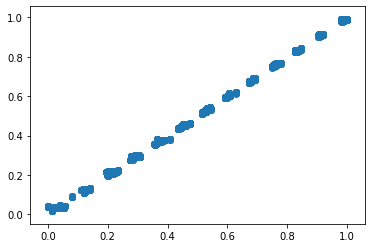

In [80]:
plt.scatter(y_cv_length, y_cv_length_pred)

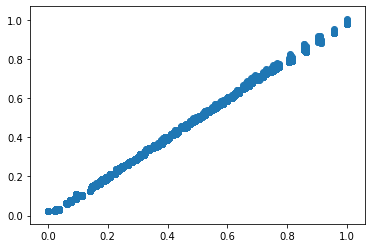

In [81]:
plt.scatter(y_cv_width, y_cv_width_pred)

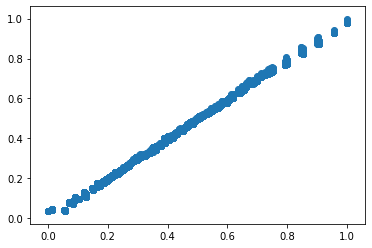

In [82]:
plt.scatter(y_cv_depth, y_cv_depth_pred)

### Validation

In [83]:
meltpool_validation = pd.read_csv(os.path.join(work_dir, '1/Validation', 'Joined_Melt_Pool_cv.csv'), index_col = False).drop(["Unnamed: 0"], axis=1)
print(meltpool_validation.shape)
meltpool_validation.head()

(80256, 9)


,X_Coord,Y_Coord,Z_Coord,Temp,Laser_Speed,Laser_Power,Melt_Pool_Length,Melt_Pool_Width,Melt_Pool_Depth
0,0.18,-0.21,0.0,0.00009,0.65,250,0.5172,0.6458,0.6286
1,0.15,-0.21,0.0,0.00009,0.65,250,0.5172,0.6458,0.6286
2,0.12,-0.21,0.0,0.00010,0.65,250,0.5172,0.6458,0.6286
3,0.09,-0.21,0.0,0.00011,0.65,250,0.5172,0.6458,0.6286
4,0.06,-0.21,0.0,0.00015,0.65,250,0.5172,0.6458,0.6286


In [84]:
X_test = meltpool_validation[['X_Coord', 'Y_Coord', 'Z_Coord', 'Temp', 'Laser_Speed', 'Laser_Power']]
y_test = meltpool_validation[['Melt_Pool_Length', 'Melt_Pool_Width', 'Melt_Pool_Depth']]

In [85]:
ys_test_pred = model_joined.predict(X_test)

In [86]:
y_test_length = y_test[["Melt_Pool_Length"]]
y_test_width = y_test[["Melt_Pool_Width"]]
y_test_depth = y_test[["Melt_Pool_Depth"]]

In [87]:
y_test_length_pred = ys_test_pred[0]
y_test_width_pred = ys_test_pred[1]
y_test_depth_pred = ys_test_pred[2]

In [88]:
print(f"Length score: {r2_score(y_test_length, y_test_length_pred)}")
print(f"Width score: {r2_score(y_test_width, y_test_width_pred)}")
print(f"Depth score: {r2_score(y_test_depth, y_test_depth_pred)}")

Length score: 0.9993727297489365
Width score: 0.9985781900720492
Depth score: 0.9965764358750705


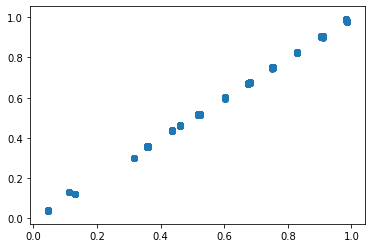

In [89]:
plt.scatter(y_test_length, y_test_length_pred)

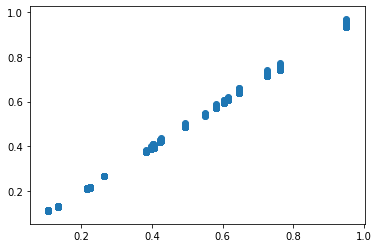

In [90]:
plt.scatter(y_test_width, y_test_width_pred)

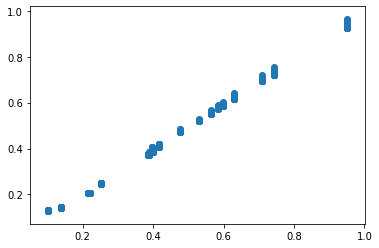

In [91]:
plt.scatter(y_test_depth, y_test_depth_pred)

### Svae model

In [92]:
# Save model
model_name = 'joined_nn_task_1.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model_joined.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\tangc\OneDrive\Desktop\Files\HW\Datathon\saved_models\joined_nn_task_1.h5 


### Prediction

In [ ]:
!conda install -c conda-forge catboost

In [99]:
import pickle
import catboost

ModuleNotFoundError: No module named 'catboost'

In [98]:
model_1b = pickle.load(open(r"saved_models\cat_1b_depth.sav", 'rb'))

ModuleNotFoundError: No module named 'catboost'